In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c3600d56-9617-c226-0d54-7b5e4a5b2e09)


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines oftext as a list.

  Args:
    filename: a string containing the target filepath
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")

In [ ]:
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
def preprocess_text(filpath):
  train_lines = get_lines(filpath)
  res = []
  map = {}
  abs = ""
  t=0
  for train_line in train_lines:
    if '###' in train_line:
      start_id = train_line
      abs = ''
      i = 0
    elif train_line.isspace():
      abs_split = abs.splitlines()
      i = len(abs_split)
      for a_num, a in enumerate(abs_split):
        map['line_number'] = a_num
        map['target'] = a.split('\t')[0]
        map['text'] = a.split('\t')[1]
        map['total_lines'] = i - 1
        res.append(map)
        map = {}
      t = a_num
    else:
      abs += train_line

  return res

In [ ]:
%%time
train_samples = preprocess_text("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
val_samples = preprocess_text(data_dir + 'dev.txt')
test_samples = preprocess_text(data_dir + 'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 425 ms, sys: 89.7 ms, total: 515 ms
Wall time: 520 ms


In [ ]:
train_samples[:15]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures include

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(train_samples)

train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

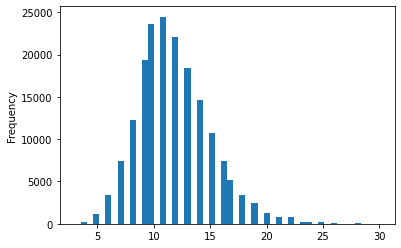

In [ ]:
train_df.total_lines.plot.hist(bins=50)

In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [ ]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('clf', MultinomialNB())
])
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
import tensorflow as tf
tf.shape(val_sentences)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([30212], dtype=int32)>

In [ ]:
!cp /content/drive/MyDrive/helper_functions.py /content
from helper_functions import *

y_pred = model_0.predict(val_sentences)
baseline_score = calculate_results(val_labels_encoded, y_pred)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=68000,
 output_mode='int',
 output_sequence_length=55)

vectorize_layer.adapt(train_sentences)

In [ ]:
rct_20k_text_vocab = vectorize_layer.get_vocabulary()
len(rct_20k_text_vocab)
vectorize_layer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [ ]:
embedding = tf.keras.layers.Embedding(len(rct_20k_text_vocab),
                                      128,
                                      mask_zero=True)

embedding(vectorize_layer(train_sentences[0]))

<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[ 0.01792381, -0.04792679,  0.0092857 , ..., -0.04236339,
        -0.04108094, -0.03006438],
       [ 0.04351567, -0.02982293,  0.02262746, ..., -0.02007054,
         0.02074425,  0.03570945],
       [ 0.01307329,  0.03304105,  0.02419731, ...,  0.01130273,
        -0.04080851,  0.01938597],
       ...,
       [-0.03102058,  0.03769782,  0.01731345, ...,  0.04298807,
         0.03915096,  0.02569756],
       [-0.03102058,  0.03769782,  0.01731345, ...,  0.04298807,
         0.03915096,  0.02569756],
       [-0.03102058,  0.03769782,  0.01731345, ...,  0.04298807,
         0.03915096,  0.02569756]], dtype=float32)>

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
tf.random.set_seed(42)

inputs = tf.keras.Input((1,), dtype='string')
x = vectorize_layer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax', dtype=tf.float32)(x)
model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
import numpy as np

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
model_1.fit(train_dataset, validation_data=valid_dataset, steps_per_epoch=int(0.1*len(train_dataset)), validation_steps=int(0.1*len(valid_dataset)),
          epochs=5, callbacks=[create_tensorboard_callback('NLP', "model_1_conv1D_2")])

In [ ]:
baseline_score

In [ ]:
model_1.evaluate(valid_dataset)

In [ ]:
y_pred = model_1.predict(valid_dataset)
y_pred.shape

In [ ]:
model_1_score = calculate_results(val_labels_encoded, y_pred.argmax(axis=1))
model_1_score

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
from tensorflow.keras import layers

In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs, 64) # tokenize text and create embedding
x = layers.LSTM(128)(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax", dtype=tf.float32)(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.fit(train_dataset, validation_data=valid_dataset, steps_per_epoch=int(0.1*len(train_dataset)), validation_steps=int(0.1*len(valid_dataset)),
          epochs=5, callbacks=[create_tensorboard_callback('NLP', "model_2_feature_extraction_Dense_layer")])

In [ ]:
y_pred = model_2.predict(valid_dataset)
y_pred.argmax()
model_2_score = calculate_results(val_labels_encoded, y_pred.argmax(axis=1))

In [ ]:
model_2_score

In [ ]:
baseline_score

In [ ]:
model_1_score

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
char_len = [len(sentence) for sentence in train_sentences]


In [ ]:
int(np.percentile(char_len, 95))

290

In [ ]:
len(char_len) + 2

180042

In [ ]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=137,
                                                    output_sequence_length=290
                                                  )
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
char_vocab[-5:]

['k', 'x', 'z', 'q', 'j']

In [ ]:
char_embedding = tf.keras.layers.Embedding(len(char_vocab),
                                      25,
                                      mask_zero=True)

In [ ]:
len(train_chars), train_labels_one_hot.shape

(180040, (180040, 5))

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
validation_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

inputs = tf.keras.Input((1,), dtype='string')
x = char_vectorizer(inputs)
x = char_embedding(x)
x = tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax', dtype=tf.float32)(x)
model_3 = tf.keras.Model(inputs, outputs)


model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
model_3.fit(train_char_dataset, validation_data=validation_char_dataset, steps_per_epoch=int(0.1*len(train_dataset)), validation_steps=int(0.1*len(valid_dataset)),
          epochs=5)

Epoch 1/5


KeyboardInterrupt: ignored

In [ ]:
y_pred = model_3.predict(validation_char_dataset)
y_pred = y_pred.argmax(axis=1)
val_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
model_3_results = calculate_results(val_labels_encoded, y_pred)

In [ ]:
model_3_results

{'accuracy': 69.04872236197538,
 'f1': 0.6902370282233169,
 'precision': 0.7003110329408795,
 'recall': 0.6904872236197538}

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

#Getting The Data ready for out Model 

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_dataset

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#Compiling and fitting Model_4

In [ ]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(lr=0.1),
                metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch= int(0.1*len(train_char_token_dataset)),
                              epochs=5,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/5
562/562 [==============================] - 42s 53ms/step - loss: 1.2350 - accuracy: 0.4958 - val_loss: 0.9223 - val_accuracy: 0.6190
Epoch 2/5
562/562 [==============================] - 27s 48ms/step - loss: 0.9520 - accuracy: 0.6087 - val_loss: 0.8552 - val_accuracy: 0.6516
Epoch 3/5
562/562 [==============================] - 26s 45ms/step - loss: 0.9082 - accuracy: 0.6326 - val_loss: 0.8300 - val_accuracy: 0.6556
Epoch 4/5
562/562 [==============================] - 34s 61ms/step - loss: 0.8719 - accuracy: 0.6514 - val_loss: 0.7928 - val_accuracy: 0.6902
Epoch 5/5
562/562 [==============================] - 27s 47ms/step - loss: 0.8670 - accuracy: 0.6580 - val_loss: 0.7892 - val_accuracy: 0.6872


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 22s 23ms/step - loss: 0.7989 - accuracy: 0.6802


[0.7989279627799988, 0.680193305015564]

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

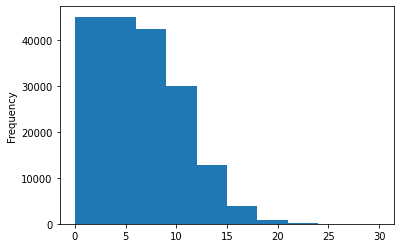

In [ ]:
train_df.line_number.plot.hist()

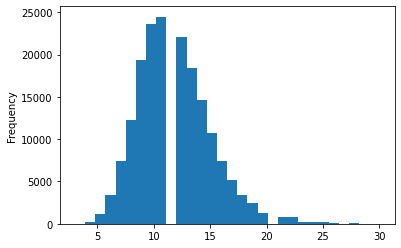

In [ ]:
import matplotlib.pyplot as plt

train_df.total_lines.plot.hist(bins=30)

0         11
1         11
2         11
3         11
4         11
          ..
180035    11
180036    11
180037    11
180038    11
180039    11
Name: total_lines, Length: 174993, dtype: int64

In [ ]:
train_total_line_one_hot_encoded = tf.one_hot(train_df['total_lines'], depth=20)
val_total_line_one_hot_encoded = tf.one_hot(val_df['total_lines'], depth=20)
test_total_line_one_hot_encoded = tf.one_hot(test_df['total_lines'], depth=20)

train_total_line_one_hot_encoded

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
tf.keras.mixed_precision.set_global_policy('float32')

#Building Model_5

In [ ]:
# Creating token_model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# Creating char_model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# Creating total lines model
total_line_inputs = layers.Input((20,), name='total_lines_inputes')
total_line_outputs = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs=total_line_inputs,
                             outputs=total_line_outputs)


# Creating line number model
line_number_inputs = layers.Input((15,), name='line_number_inputes')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                             outputs=line_number_outputs)


token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

combined_dense = layers.Dense(256, activation="relu")(token_char_concat) # slightly different to Figure 1 due to different shapes of token/char embedding layers
z = layers.Dropout(0.5)(combined_dense)


tribrid_embeddings = layers.Concatenate(name='lines_concate')([total_line_model.output,
                                                               line_number_model.output,
                                                               z])

output_layer = layers.Dense(num_classes, activation='softmax')(tribrid_embeddings)

# 5. Construct model with char and token inputs
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input, total_line_model.input],
                         outputs=output_layer,
                         name="model_5_token_and_char_embeddings")

In [ ]:
model_5.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

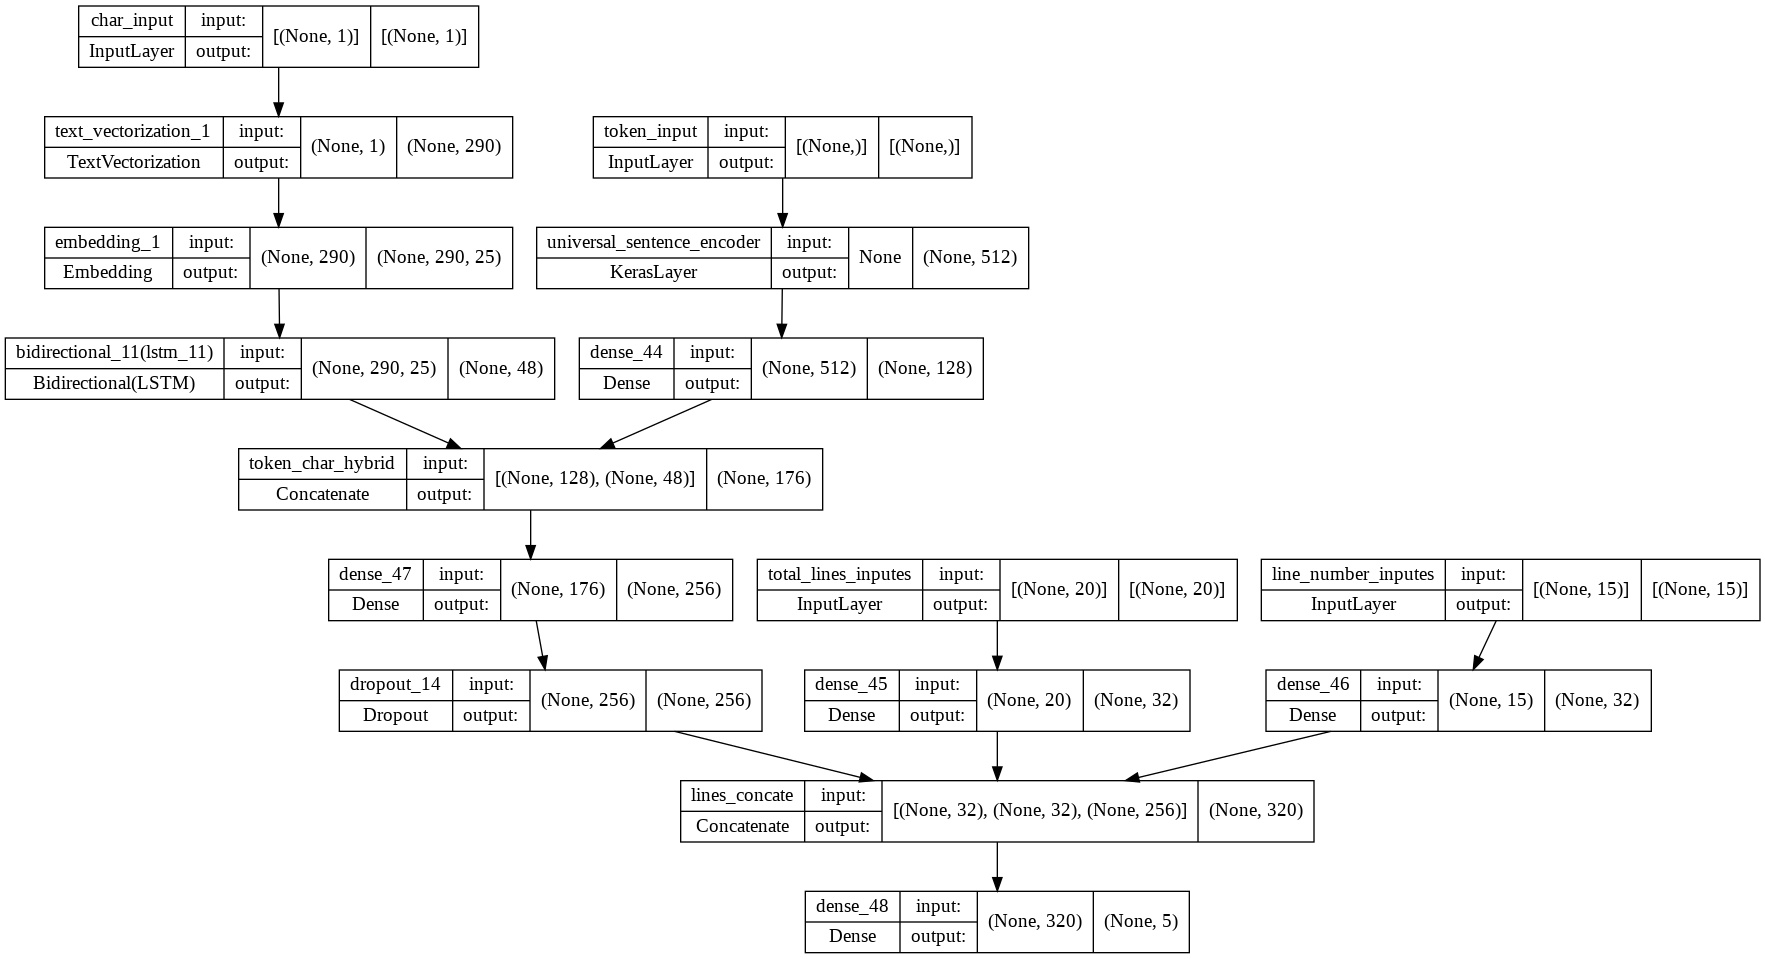

In [ ]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

352

In [ ]:
# Creating the train data with 4 inputs
train_char_token_lines_inputes = tf.data.Dataset.from_tensor_slices([train_sentences,train_chars,train_total_line_one_hot_encoded,train_line_numbers_one_hot])
train_char_token_lines_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_lines = tf.data.Dataset.zip((train_char_toke_lines_inputes, train_char_toke_lines_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_lines

NameError: ignored

In [ ]:
# Creating the validation data with 4 inputs
val_char_token_lines_inputes = tf.data.Dataset.from_tensor_slices([val_sentences,val_chars,val_total_line_one_hot_encoded,val_line_numbers_one_hot])
val_char_token_lines_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_lines = tf.data.Dataset.zip((val_char_toke_lines_inputes, val_char_toke_lines_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Creating the test data with 4 inputs
test_char_token_lines_inputes = tf.data.Dataset.from_tensor_slices([test_sentences,test_chars,test_total_line_one_hot_encoded,test_line_numbers_one_hot])
test_char_token_lines_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_lines = tf.data.Dataset.zip((test_char_toke_lines_inputes, test_char_toke_lines_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5.fit(train_char_token_lines, epochs=3, steps_per_epoch=int(0.*len(train_char_token_lines)), validation_data=val_char_token_lines,
            validation_steps=int(0.1*len(val_char_token_lines)))

NameError: ignored